# FML Homework 3 - Erin Choi

## Data Preprocessing

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics, model_selection, tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [2]:
# load data
origdata = pd.read_csv('diabetes.csv', encoding='utf-8')
origdata.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


In [3]:
# how many rows are in the data?
origdata.shape

(253680, 22)

In [4]:
# which columns have null values?
origdata.isnull().sum()

Diabetes                 0
HighBP                   0
HighChol                 0
BMI                      0
Smoker                   0
Stroke                   0
Myocardial               0
PhysActivity             0
Fruit                    0
Vegetables               0
HeavyDrinker             0
HasHealthcare            0
NotAbleToAffordDoctor    0
GeneralHealth            0
MentalHealth             0
PhysicalHealth           0
HardToClimbStairs        0
BiologicalSex            0
AgeBracket               0
EducationBracket         0
IncomeBracket            0
Zodiac                   0
dtype: int64

In [5]:
# make a copy of data to make preprocessing changes on
data = origdata.copy()

In [6]:
# determine diff types of features: binary, ordinal, categorical, and continuous
binary = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'Myocardial', 'PhysActivity',
          'Fruit', 'Vegetables', 'HeavyDrinker', 'HasHealthcare', 'NotAbleToAffordDoctor', 
          'HardToClimbStairs', 'BiologicalSex']
ordinal = ['GeneralHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket']
cat = ['Zodiac']
cont = ['BMI', 'MentalHealth', 'PhysicalHealth']

In [7]:
# change gender variable to 0/1 rather than 1/2 for consistency between binary features
data.loc[(data['BiologicalSex']==2, 'BiologicalSex')] = 0
data['BiologicalSex'].unique()

array([1, 0])

In [8]:
# drop zodiac
data.drop(columns=['Zodiac'], inplace=True)
data.shape

(253680, 21)

In [9]:
# scale continuous & ordinal features using MinMaxScaler
# so they're between 0 and 1 (like binary variables being 0/1)
contord = cont + ordinal
scaler = MinMaxScaler()
contord_scaled = scaler.fit_transform(pd.DataFrame(data[contord]))
for i in range(len(contord)):
    data[contord[i]] = contord_scaled[:,i]
data[contord].head()

,BMI,MentalHealth,PhysicalHealth,GeneralHealth,AgeBracket,EducationBracket,IncomeBracket
0,0.325581,0.6,0.5,1.00,0.666667,0.6,0.285714
1,0.151163,0.0,0.0,0.50,0.500000,1.0,0.000000
2,0.186047,1.0,1.0,1.00,0.666667,0.6,1.000000
3,0.174419,0.0,0.0,0.25,0.833333,0.4,0.714286
4,0.139535,0.1,0.0,0.25,0.833333,0.8,0.428571


In [10]:
# check class balance - very imbalanced
data['Diabetes'].value_counts()

0    218334
1     35346
Name: Diabetes, dtype: int64

In [11]:
# separate features from target
dataX = data.copy().drop(columns=['Diabetes'])
dataY = pd.DataFrame(data.copy()['Diabetes'])

In [12]:
# split data into train/test sets, using StratifiedShuffleSplit
# to make sure sets have the same proportion of diabetes classes
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(dataX, dataY):
    xTrain = dataX.loc[train_index]
    yTrain = dataY.loc[train_index]
    xTest = dataX.loc[test_index]
    yTest = dataY.loc[test_index]
    
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(202944, 20) (50736, 20) (202944, 1) (50736, 1)


## Question 1
**Build a logistic regression model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?**

In [13]:
# train lr model
lr = LogisticRegression(class_weight='balanced', 
                            solver = 'liblinear').fit(pd.DataFrame(xTrain), 
                                                         yTrain.values.flatten());
yPred_lr = lr.predict(pd.DataFrame(xTest))
yProb_lr = lr.predict_proba(xTest)[:,1]

# predict and evaluate on test set
print("Logistic Regression Model")

auroc_lr = roc_auc_score(yTest, yProb_lr)
print("AUROC = {:0.3f}".format(auroc_lr))

auprc_lr = average_precision_score(yTest, yProb_lr)
print("AUPRC = {:0.3f}".format(auprc_lr))

acc_lr = accuracy_score(yTest, yPred_lr)
print("Accuracy = {:0.2f}%".format(acc_lr * 100))

f1_lr = f1_score(yTest, yPred_lr)
print("F1 Score = {:0.3f}".format(f1_lr))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_lr))
# tn fp / fn tp

Logistic Regression Model
AUROC = 0.818
AUPRC = 0.391
Accuracy = 73.08%
F1 Score = 0.440
Confusion matrix:
 [[31707 11960]
 [ 1700  5369]]


In [53]:
# look for best predictor based on AUROC and AUPRC:
# iterate through columns, drop each, and run model
lr_best = {}
lr_best_pr = {}

for p in xTrain.columns:
    xTrainDrop = xTrain.copy().drop(columns=[p])
    xTestDrop = xTest.copy().drop(columns=[p])
    
    temp_lr = LogisticRegression(class_weight='balanced', 
                            solver = 'liblinear').fit(pd.DataFrame(xTrainDrop), 
                                                         yTrain.values.flatten());
    
    auroc = roc_auc_score(yTest, temp_lr.predict_proba(xTestDrop)[:,1])
    auprc = average_precision_score(yTest, temp_lr.predict_proba(xTestDrop)[:,1])
    lr_best[p] = auroc
    lr_best_pr[p] = auprc

In [81]:
# find the column that, when dropped, yielded the lowest AUC
lr_best_pred1 = min(lr_best.items(), key=lambda x:x[1])
print("Best Predictor AUROC:", lr_best_pred1[0],
     "\nAUC of Model excluding best predictor:", lr_best_pred1[1],
     "\nDifference in AUC from overall model:", lr_best_pred1[1]-auroc_lr)

Best Predictor AUROC: GeneralHealth 
AUC of Model excluding best predictor: 0.8028153068052168 
Difference in AUC from overall model: -0.015320223231788277


In [82]:
# find the column that, when dropped, yielded the lowest AUPRC
lr_best_pred2 = min(lr_best_pr.items(), key=lambda x:x[1])
print("Best Predictor AUPRC:", lr_best_pred2[0],
     "\nAUPRC of Model excluding best predictor:", lr_best_pred2[1],
     "\nDifference in AUPRC from overall model:", lr_best_pred2[1]-auprc_lr)

Best Predictor AUPRC: BMI 
AUPRC of Model excluding best predictor: 0.36402941073901435 
Difference in AUPRC from overall model: -0.027049936240843564


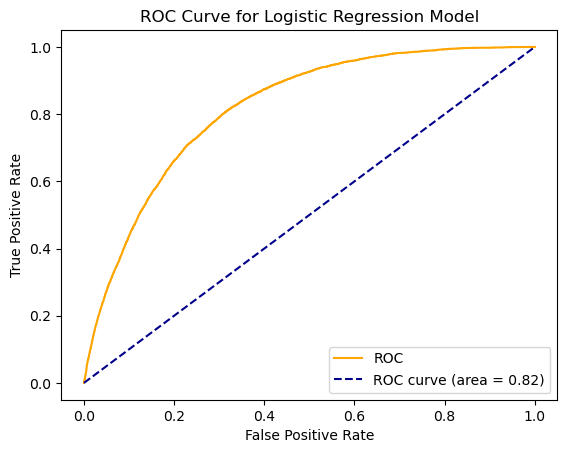

In [58]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_lr)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auroc_lr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend()
plt.show()

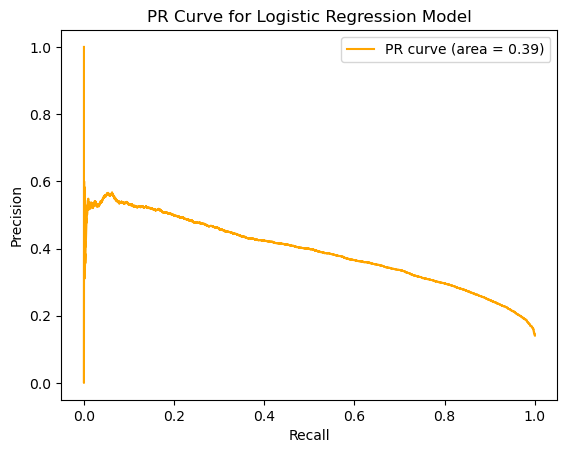

In [59]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_lr)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.2f)' % auprc_lr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Logistic Regression Model')
plt.legend()
plt.show()

## Question 2
**Build a SVM. Doing so: What is the best predictor of diabetes and what is the AUC of this model?**

In [219]:
# train linear SVM
np.random.seed(17)
svm = LinearSVC(dual = False, class_weight='balanced').fit(xTrain, yTrain.values.flatten())
# squared-hinge loss function is better than hinge loss
# wasn't able to improve the model by changing C hyperparameter or penalty

# predict
yPred_svm = svm.predict(xTest)
yProb_svm = svm.decision_function(xTest)

# evaluate on test set
print("SVM")

auroc_svm = roc_auc_score(yTest, yProb_svm)
print("AUROC = {:0.3f}".format(auroc_svm))

auprc_svm = average_precision_score(yTest, yProb_svm)
print("AUPRC = {:0.3f}".format(auprc_svm))

acc_svm = accuracy_score(yTest, yPred_svm)
print("Accuracy = {:0.2f}%".format(acc_svm * 100))

f1_svm = f1_score(yTest, yPred_svm)
print("F1 Score = {:0.3f}".format(f1_svm))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_svm))
# tn fp / fn tp

SVM
AUROC = 0.818
AUPRC = 0.392
Accuracy = 72.74%
F1 Score = 0.439
Confusion matrix:
 [[31491 12176]
 [ 1657  5412]]


In [77]:
# look for best predictor based on AUROC and AUPRC:
# iterate through columns, drop each, and run model
svm_best = {}
svm_best_pr = {}

for p in xTrain.columns:
    xTrainDrop = xTrain.copy().drop(columns=[p])
    xTestDrop = xTest.copy().drop(columns=[p])
    
    temp_svm = LinearSVC(dual = False, class_weight='balanced').fit(xTrainDrop, yTrain.values.flatten())
    
    auroc = roc_auc_score(yTest, temp_svm.decision_function(xTestDrop))
    auprc = average_precision_score(yTest, temp_svm.decision_function(xTestDrop))
    svm_best[p] = auroc
    svm_best_pr[p] = auprc

In [83]:
# find the column that, when dropped, yielded the lowest AUC
svm_best_pred1 = min(svm_best.items(), key=lambda x:x[1])
print("Best Predictor AUROC:", svm_best_pred1[0],
     "\nAUC of Model excluding best predictor:", svm_best_pred1[1],
     "\nDifference in AUC from overall model:", svm_best_pred1[1]-auroc_svm)

Best Predictor AUROC: GeneralHealth 
AUC of Model excluding best predictor: 0.802317056215483 
Difference in AUC from overall model: -0.015590468966182658


In [88]:
# find the column that, when dropped, yielded the lowest AUPRC
svm_best_pred2 = min(svm_best_pr.items(), key=lambda x:x[1])
print("Best Predictor AUPRC:", svm_best_pred2[0],
     "\nAUPRC of Model excluding best predictor:", svm_best_pred2[1],
     "\nDifference in AUPRC from overall model:", svm_best_pred2[1]-auprc_svm)

Best Predictor AUPRC: BMI 
AUPRC of Model excluding best predictor: 0.36441868905941355 
Difference in AUPRC from overall model: -0.027634697957802157


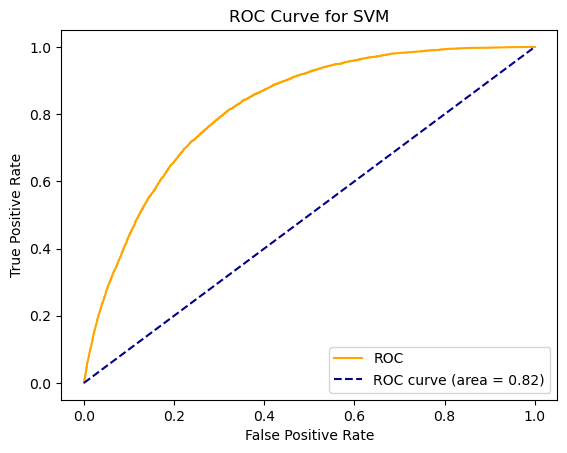

In [89]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_svm)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auroc_svm)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend()
plt.show()

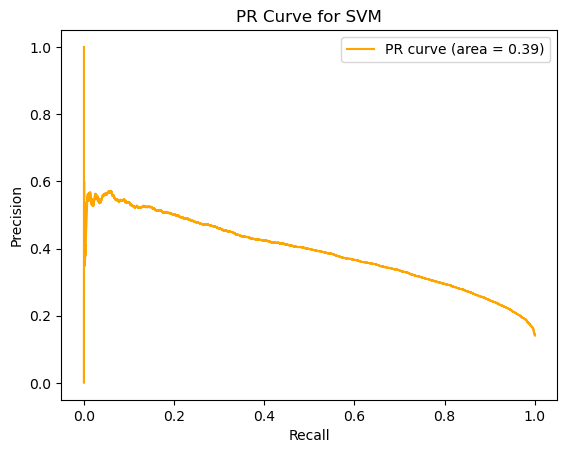

In [90]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_svm)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.2f)' % auprc_svm)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for SVM')
plt.legend()
plt.show()

## Question 3
**Use a single, individual decision tree. Doing so: What is the best predictor of diabetes and what is the AUC of this model?**

In [220]:
# train decision tree
np.random.seed(17)
dtc = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=201,
                                  class_weight='balanced', 
                                  random_state=17).fit(xTrain, yTrain.values.flatten())
# hyperparameters tuned to increase auc:
# min_samples_split (default 2: yielded auc 0.60, auprc 0.19, accuracy 0.797, f1 0.30)
 
# predict
yPred_dtc = dtc.predict(xTest)
yProb_dtc = dtc.predict_proba(xTest)[:,1]

# evaluate on test set
print("Decision Tree")

auroc_dtc = roc_auc_score(yTest, yProb_dtc)
print("AUROC = {:0.3f}".format(auroc_dtc))

auprc_dtc = average_precision_score(yTest, yProb_dtc)
print("AUPRC = {:0.3f}".format(auprc_dtc))

acc_dtc = accuracy_score(yTest, yPred_dtc)
print("Accuracy = {:0.2f}%".format(acc_dtc * 100))

f1_dtc = f1_score(yTest, yPred_dtc)
print("F1 Score = {:0.3f}".format(f1_dtc))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_dtc))
# tn fp / fn tp

Decision Tree
AUROC = 0.799
AUPRC = 0.383
Accuracy = 71.25%
F1 Score = 0.424
Confusion matrix:
 [[30790 12877]
 [ 1710  5359]]


In [142]:
# look for best predictor based on AUROC and AUPRC:
# iterate through columns, drop each, and run model
dtc_best = {}
dtc_best_pr = {}

for p in xTrain.columns:
    xTrainDrop = xTrain.copy().drop(columns=[p])
    xTestDrop = xTest.copy().drop(columns=[p])
    
    temp_dtc = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=201,
                                  class_weight='balanced', 
                                  random_state=17).fit(xTrainDrop, yTrain.values.flatten())
    
    auroc = roc_auc_score(yTest, temp_dtc.predict_proba(xTestDrop)[:,1])
    auprc = average_precision_score(yTest, temp_dtc.predict_proba(xTestDrop)[:,1])
    dtc_best[p] = auroc
    dtc_best_pr[p] = auprc

In [143]:
# find the column that, when dropped, yielded the lowest AUC
dtc_best_pred1 = min(dtc_best.items(), key=lambda x:x[1])
print("Best Predictor AUROC:", dtc_best_pred1[0],
     "\nAUC of Model excluding best predictor:", dtc_best_pred1[1],
     "\nDifference in AUC from overall model:", dtc_best_pred1[1]-auroc_dtc)

Best Predictor AUROC: GeneralHealth 
AUC of Model excluding best predictor: 0.7810984606641638 
Difference in AUC from overall model: -0.017860941322132007


In [144]:
# find the column that, when dropped, yielded the lowest AUPRC
dtc_best_pred2 = min(dtc_best_pr.items(), key=lambda x:x[1])
print("Best Predictor AUPRC:", dtc_best_pred2[0],
     "\nAUPRC of Model excluding best predictor:", dtc_best_pred2[1],
     "\nDifference in AUPRC from overall model:", dtc_best_pred2[1]-auprc_dtc)

Best Predictor AUPRC: BMI 
AUPRC of Model excluding best predictor: 0.3546105843912441 
Difference in AUPRC from overall model: -0.028333052106349066


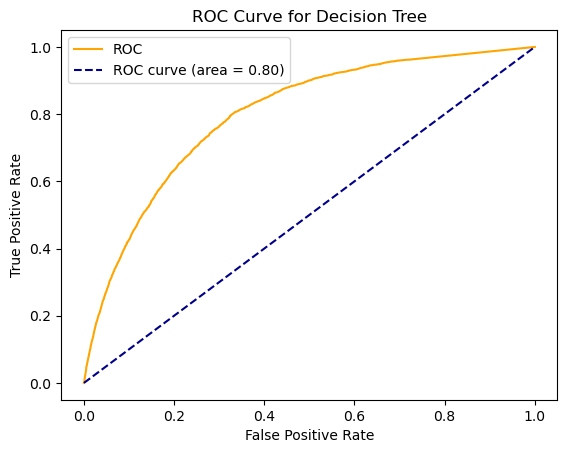

In [145]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_dtc)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auroc_dtc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend()
plt.show()

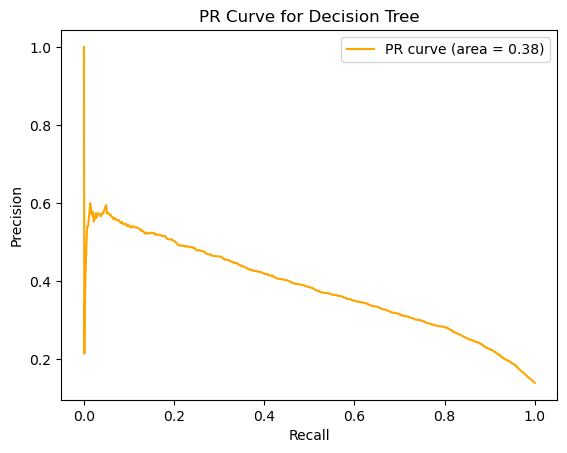

In [146]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_dtc)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.2f)' % auprc_dtc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Decision Tree')
plt.legend()
plt.show()

## Question 4
**Build a random forest model. Doing so: What is the best predictor of diabetes and what is the AUC of this model?**

In [26]:
# train random forest
np.random.seed(17)
rf = RandomForestClassifier(n_estimators=100, max_samples=1.0,
                            bootstrap=True, criterion='gini', min_samples_split=30,
                            class_weight="balanced", random_state=17).fit(xTrain, yTrain.values.flatten())

# hyperparameters tuned to increase auc:
# min_samples_split (default 2)
# default metrics: AUROC = 0.79, AUPRC = 0.36, Accuracy = 85.69%, F1 Score = 0.24
# changing criterion didn't affect the results much, 
# decreasing the proportion of max_features made performance worse
 
# predict
yPred_rf = rf.predict(xTest)
yProb_rf = rf.predict_proba(xTest)[:,1]

# evaluate on test set
print("Random Forest Model")

auroc_rf = roc_auc_score(yTest, yProb_rf)
print("AUROC = {:0.3f}".format(auroc_rf))

auprc_rf = average_precision_score(yTest, yProb_rf)
print("AUPRC = {:0.3f}".format(auprc_rf))

acc_rf = accuracy_score(yTest, yPred_rf)
print("Accuracy = {:0.2f}%".format(acc_rf * 100))

f1_rf = f1_score(yTest, yPred_rf)
print("F1 Score = {:0.3f}".format(f1_rf))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_rf))
# tn fp / fn tp

Random Forest Model
AUROC = 0.820
AUPRC = 0.414
Accuracy = 78.21%
F1 Score = 0.458
Confusion matrix:
 [[35002  8665]
 [ 2391  4678]]


In [185]:
# look for best predictor based on AUROC and AUPRC:
# iterate through columns, drop each, and run model
rf_best = {}
rf_best_pr = {}

for p in xTrain.columns:
    xTrainDrop = xTrain.copy().drop(columns=[p])
    xTestDrop = xTest.copy().drop(columns=[p])
    
    temp_rf = RandomForestClassifier(n_estimators=100, max_samples=1.0,
                            bootstrap=True, criterion='gini', min_samples_split=30,
                            class_weight="balanced", random_state=17).fit(xTrainDrop, yTrain.values.flatten())
    
    auroc = roc_auc_score(yTest, temp_rf.predict_proba(xTestDrop)[:,1])
    auprc = average_precision_score(yTest, temp_rf.predict_proba(xTestDrop)[:,1])
    rf_best[p] = auroc
    rf_best_pr[p] = auprc

In [186]:
# find the column that, when dropped, yielded the lowest AUC
rf_best_pred1 = min(rf_best.items(), key=lambda x:x[1])
print("Best Predictor AUROC:", rf_best_pred1[0],
     "\nAUC of Model excluding best predictor:", rf_best_pred1[1],
     "\nDifference in AUC from overall model:", rf_best_pred1[1]-auroc_rf)

Best Predictor AUROC: GeneralHealth 
AUC of Model excluding best predictor: 0.8020103473923391 
Difference in AUC from overall model: -0.01754220717932775


In [187]:
# find the column that, when dropped, yielded the lowest AUPRC
rf_best_pred2 = min(rf_best_pr.items(), key=lambda x:x[1])
print("Best Predictor AUPRC:", rf_best_pred2[0],
     "\nAUPRC of Model excluding best predictor:", rf_best_pred2[1],
     "\nDifference in AUPRC from overall model:", rf_best_pred2[1]-auprc_rf)

Best Predictor AUPRC: BMI 
AUPRC of Model excluding best predictor: 0.38006028513803114 
Difference in AUPRC from overall model: -0.03377755232460067


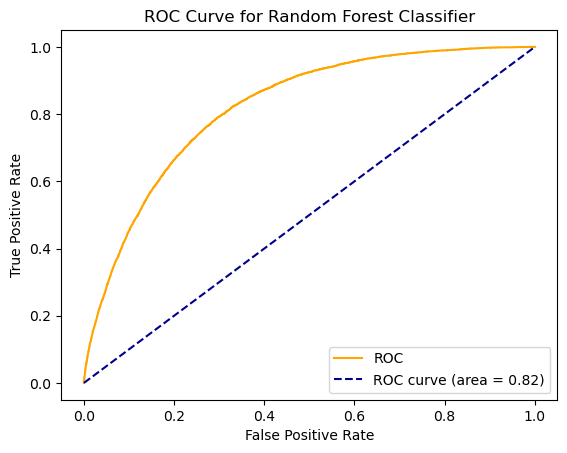

In [27]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_rf)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auroc_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend()
plt.show()

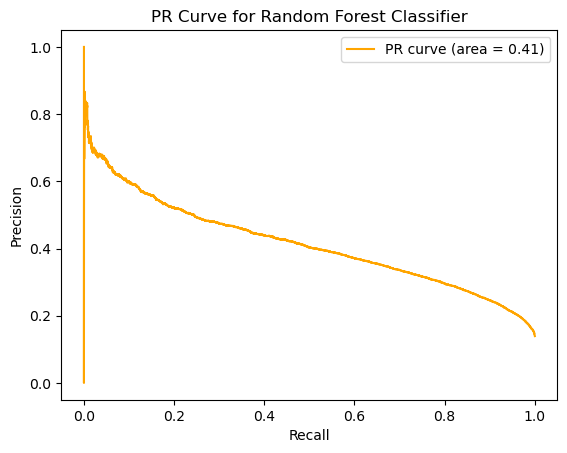

In [28]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_rf)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.2f)' % auprc_rf)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Random Forest Classifier')
plt.legend()
plt.show()

## Question 5
**Build a model using adaBoost. Doing so: What is the best predictor of diabetes and what is the AUC of this model?**

In [216]:
# train adaboost classifier
np.random.seed(17)
abc = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=1, criterion="entropy", class_weight='balanced',
                                min_samples_split=100, random_state=17), 
    n_estimators=100, random_state=17).fit(xTrain, yTrain.values.flatten())
# decision tree with max_depth = 1 is default estimator for AdaBoost
# increased min_samples_split from default 2 to 100
# and n_estimators from default 50 to 100
# original AUROC = 0.77, AUPRC = 0.29, Accuracy = 81.01%, F1 Score = 0.34

# predict
yPred_abc = abc.predict(xTest)
yProb_abc = abc.predict_proba(xTest)[:,1]

# evaluate on test set
print("AdaBoost Classifier")

auroc_abc = roc_auc_score(yTest, yProb_abc)
print("AUROC = {:0.3f}".format(auroc_abc))

auprc_abc = average_precision_score(yTest, yProb_abc)
print("AUPRC = {:0.3f}".format(auprc_abc))

acc_abc = accuracy_score(yTest, yPred_abc)
print("Accuracy = {:0.2f}%".format(acc_abc * 100))

f1_abc = f1_score(yTest, yPred_abc)
print("F1 Score = {:0.3f}".format(f1_abc))

print("Confusion matrix:\n", confusion_matrix(yTest, yPred_abc))
# tn fp / fn tp

AdaBoost Classifier
AUROC = 0.822
AUPRC = 0.412
Accuracy = 73.11%
F1 Score = 0.442
Confusion matrix:
 [[31689 11978]
 [ 1665  5404]]


In [224]:
# look for best predictor based on AUROC and AUPRC:
# iterate through columns, drop each, and run model
abc_best = {}
abc_best_pr = {}

for p in xTrain.columns:
    xTrainDrop = xTrain.copy().drop(columns=[p])
    xTestDrop = xTest.copy().drop(columns=[p])
    
    temp_abc = AdaBoostClassifier(
                tree.DecisionTreeClassifier(max_depth=1, criterion="entropy", class_weight='balanced',
                                            min_samples_split=100, random_state=17), 
                n_estimators=100, random_state=17).fit(xTrainDrop, yTrain.values.flatten())
    
    auroc = roc_auc_score(yTest, temp_abc.predict_proba(xTestDrop)[:,1])
    auprc = average_precision_score(yTest, temp_abc.predict_proba(xTestDrop)[:,1])
    abc_best[p] = auroc
    abc_best_pr[p] = auprc

In [226]:
# find the column that, when dropped, yielded the lowest AUC
abc_best_pred1 = min(abc_best.items(), key=lambda x:x[1])
print("Best Predictor AUROC:", abc_best_pred1[0],
     "\nAUC of Model excluding best predictor:", abc_best_pred1[1],
     "\nDifference in AUC from overall model:", abc_best_pred1[1]-auroc_abc)

Best Predictor AUROC: BMI 
AUC of Model excluding best predictor: 0.8062290268196151 
Difference in AUC from overall model: -0.015518637766605448


In [227]:
# find the column that, when dropped, yielded the lowest AUPRC
abc_best_pred2 = min(abc_best_pr.items(), key=lambda x:x[1])
print("Best Predictor AUPRC:", abc_best_pred2[0],
     "\nAUPRC of Model excluding best predictor:", abc_best_pred2[1],
     "\nDifference in AUPRC from overall model:", abc_best_pred2[1]-auprc_abc)

Best Predictor AUPRC: BMI 
AUPRC of Model excluding best predictor: 0.3780395948231586 
Difference in AUPRC from overall model: -0.03351802326778036


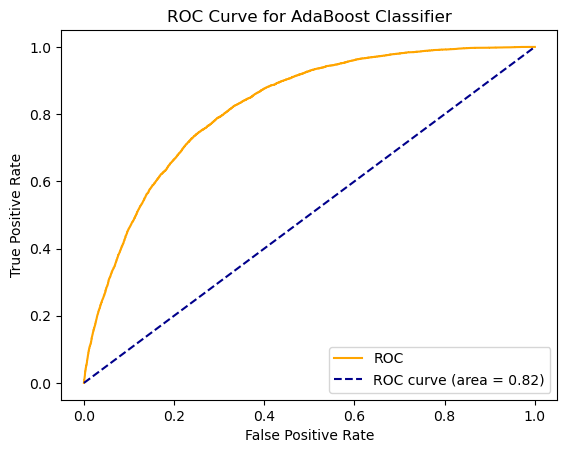

In [228]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(yTest, yProb_abc)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auroc_abc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost Classifier')
plt.legend()
plt.show()

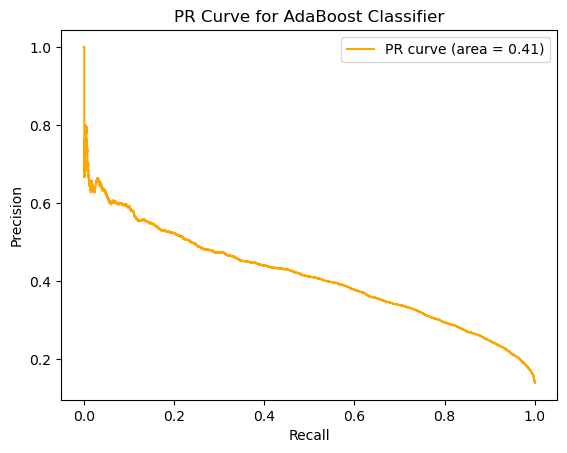

In [229]:
# plot PR curve
prec, rec, thresholds = precision_recall_curve(yTest, yProb_abc)
plt.plot(rec, prec, color='orange', label='PR curve (area = %0.2f)' % auprc_abc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for AdaBoost Classifier')
plt.legend()
plt.show()

## Extra Credit: Part A
Which of these 5 models is the best to predict diabetes in this dataset?

In [232]:
results = pd.DataFrame()
results['Model'] = ['LR', 'SVM', 'DTC', 'RF', 'ABC']
results['AUROC'] = [auroc_lr, auroc_svm, auroc_dtc, auroc_rf, auroc_abc]
results['AUPRC'] = [auprc_lr, auprc_svm, auprc_dtc, auprc_rf, auprc_abc]
results['Accuracy'] = [acc_lr, acc_svm, acc_dtc, acc_rf, acc_abc]
results['F1'] = [f1_lr, f1_svm, f1_dtc, f1_rf, f1_abc]

results

,Model,AUROC,AUPRC,Accuracy,F1
0,LR,0.818136,0.391079,0.730763,0.440118
1,SVM,0.817908,0.392053,0.727353,0.438983
2,DTC,0.798959,0.382944,0.712492,0.423553
3,RF,0.819553,0.413838,0.782088,0.458358
4,ABC,0.821748,0.411558,0.731098,0.442027


Highest Scoring Models
* Highest AUROC: AdaBoost
* Highest AUPRC: Random Forest
* Highest Accuracy: Random Forest
* Highest F1 Score: Random Forest